In [2]:
import sys
import os

# Get the absolute path of the parent directory containing 'mrq'
sys.path.append(os.path.abspath("../mrq"))

# Verify it is added
print(sys.path)
import MRQ  # Assuming mrq/utils.py exists
print(dir(MRQ))

['C:\\Users\\ernan\\AppData\\Local\\Programs\\Python\\Python311\\python311.zip', 'C:\\Users\\ernan\\AppData\\Local\\Programs\\Python\\Python311\\DLLs', 'C:\\Users\\ernan\\AppData\\Local\\Programs\\Python\\Python311\\Lib', 'C:\\Users\\ernan\\AppData\\Local\\Programs\\Python\\Python311', 'd:\\projects\\MRQ\\venv', '', 'd:\\projects\\MRQ\\venv\\Lib\\site-packages', 'd:\\projects\\MRQ\\venv\\Lib\\site-packages\\win32', 'd:\\projects\\MRQ\\venv\\Lib\\site-packages\\win32\\lib', 'd:\\projects\\MRQ\\venv\\Lib\\site-packages\\Pythonwin', 'd:\\projects\\MRQ\\mrq']
['Agent', 'Dict', 'F', 'Hyperparameters', 'TwoHot', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'buffer', 'copy', 'dataclasses', 'masked_mse', 'maybe_augment_state', 'models', 'multi_step_reward', 'np', 'realign', 'shift_aug', 'torch', 'utils']


## Getting Stock Market Data

Before training MR.Q, we need historical stock prices. We’ll use Yahoo Finance to fetch stock data. For me the data comes down in non standard CSV format. So you need to do a bit of processing to get it right. I want to add a few more columns that will allow the models to get more information from the data.

In [3]:
import yfinance as yf
import pandas as pd

def get_stock_data(symbol, start="2010-01-01", end="2024-01-01"):
    """Fetch stock data from Yahoo Finance."""
    data = yf.download(symbol, start=start, end=end)
    file_name = f"{symbol}_{start}_{end}.csv"
    data.to_csv(file_name)
    headers = ['Date','Close','High','Low','Open','Volume']

    # Load CSV while skipping the first 3 lines
    stock = pd.read_csv(file_name, skiprows=3, names=headers)
    stock["SMA_5"] = stock["Close"].rolling(window=5).mean()
    stock["SMA_20"] = stock["Close"].rolling(window=20).mean()
    stock["Return"] = stock["Close"] - stock["Open"]
    stock["Volatility"] = stock["Return"].rolling(window=5).std()
    stock = stock.iloc[20:] # calc of 20 day moving average will lead ot NaN values
    return stock

data = get_stock_data("AAPL")
FEATURES = ["Close", "SMA_5", "SMA_20", "Return", "Volatility"]
data = data[FEATURES]
data = data.astype(float)
print(data.head())


[*********************100%***********************]  1 of 1 completed

       Close     SMA_5    SMA_20    Return  Volatility
20  5.894132  5.957450  6.204051 -0.001505    0.146020
21  5.995548  5.905388  6.181255  0.122180    0.165844
22  5.779476  5.861812  6.152787 -0.140837    0.161059
23  5.882094  5.882276  6.130036  0.085164    0.104118
24  5.841772  5.878604  6.103163 -0.047247    0.105104


## Build the Buffer

The StockReplayBuffer is a memory storage system for reinforcement learning, specifically designed for stock trading agents. It stores past experiences (state, action, reward, next state, done) and retrieves random samples for training.

In [7]:
import numpy as np
import torch

class StockReplayBuffer:
    def __init__(self, max_size=100000):
        self.max_size = max_size
        self.states = []
        self.actions = []
        self.rewards = []
        self.next_states = []
        self.dones = []

    def add(self, state, action, reward, next_state, done):
        if len(self.states) >= self.max_size:
            self.states.pop(0)
            self.actions.pop(0)
            self.rewards.pop(0)
            self.next_states.pop(0)
            self.dones.pop(0)

        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
        self.next_states.append(next_state)
        self.dones.append(done)

    def sample(self, batch_size):
            indices = np.random.choice(len(self.states), batch_size, replace=False)
            
            # Convert lists to NumPy arrays before converting to tensors
            states_np = np.array(self.states, dtype=np.float32)
            actions_np = np.array(self.actions, dtype=np.int64)
            rewards_np = np.array(self.rewards, dtype=np.float32).reshape(-1, 1)
            next_states_np = np.array(self.next_states, dtype=np.float32)
            dones_np = np.array(self.dones, dtype=np.float32).reshape(-1, 1)

            return (torch.tensor(states_np)[indices],
                    torch.tensor(actions_np)[indices],
                    torch.tensor(rewards_np)[indices],
                    torch.tensor(next_states_np)[indices],
                    torch.tensor(dones_np)[indices])

##  Implement the RL Agent for Trading (policy network)
MR.Q Stock Trading Agent Implementation

In [ ]:
import torch.nn as nn
import torch.optim as optim
import random

class StockTradingAgent:
    def __init__(self, state_dim, action_dim=3, learning_rate=0.001, exploration_prob=0.2):
        self.policy_network = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, action_dim),
            nn.Softmax(dim=-1)
        )

        self.optimizer = optim.Adam(self.policy_network.parameters(), lr=learning_rate)
        self.loss_fn = nn.MSELoss()
        self.exploration_prob = exploration_prob  # Exploration rate (chance of random action)

    def select_action(self, state):
        if random.random() < self.exploration_prob:
            return random.choice([0, 1, 2])  # Random action for exploration

        with torch.no_grad():
            state_tensor = torch.tensor(state, dtype=torch.float32)
            action_probs = self.policy_network(state_tensor)
            return torch.argmax(action_probs).item()  # Choose action with highest probability

    def train(self, buffer, batch_size=32):
        """Train the agent using experiences from the replay buffer."""
        if len(buffer.states) < batch_size:
            return  # Not enough data to train

        states, actions, rewards, next_states, dones = buffer.sample(batch_size)

        # Convert actions to one-hot encoding
        actions_one_hot = torch.nn.functional.one_hot(actions, num_classes=3).float()

        # Compute predicted Q-values
        q_values = self.policy_network(states)

        # Get Q-values for the selected actions
        q_values = (q_values * actions_one_hot).sum(dim=1, keepdim=True)

        # Compute target Q-values
        next_q_values = self.policy_network(next_states).max(dim=1, keepdim=True)[0]
        target_q_values = rewards + 0.99 * next_q_values * (1 - dones)

        # Compute loss
        loss = self.loss_fn(q_values, target_q_values.detach())

        # Update the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


##  Training the RL Trading Agent

In [9]:
buffer = StockReplayBuffer()
agent = StockTradingAgent(state_dim=5)  # We use 5 features: Close, SMA_5, SMA_20, Return, Volatility

for i in range(len(data)-1):
    state = data.iloc[i].values
    next_state = data.iloc[i+1].values

    action = agent.select_action(state)

    # Reward function: Encourage profitable trades
    reward = (next_state[0] - state[0]) * (1 if action == 1 else -1)

    if action == 1 and next_state[0] > state[0]:  # Buy & price goes up ✅
        reward += 2  
    elif action == 2 and next_state[0] < state[0]:  # Sell & price drops ✅
        reward += 2  
    elif action == 1 and next_state[0] < state[0]:  # Buy & price goes down ❌
        reward -= 2  
    elif action == 2 and next_state[0] > state[0]:  # Sell & price goes up ❌
        reward -= 2  

    done = i == len(data)-2
    buffer.add(state, action, reward, next_state, done)

    # Train agent multiple times per step
    if len(buffer.states) > 32:
        for _ in range(5):  # Train 5x per step
            agent.train(buffer)


## Backtesting: Does It Make Money

In [10]:
capital = 10000  # Initial investment
holdings = 0  # Number of shares owned
portfolio_values = []  # Store portfolio value over time
dates = data.index  # Get dates for x-axis
actions_taken = []  # Store buy/sell actions for plotting

for i in range(len(data)-1):
    state = data.iloc[i].values
    action = agent.select_action(state)
    
    actions_taken.append((dates[i], action))  # Track actions

    if action == 1 and capital >= state[0]:  # Buy
        holdings += 1
        capital -= state[0]
    elif action == 2 and holdings > 0:  # Sell
        holdings -= 1
        capital += state[0]

    total_value = capital + holdings * data.iloc[i]['Close']
    portfolio_values.append(total_value)

final_value = capital + holdings * data.iloc[-1]['Close']
print(f"Final Portfolio Value: ${final_value:.2f}")
print(f"Total Profit: ${final_value - 10000:.2f}")

Final Portfolio Value: $148915.37
Total Profit: $138915.37


In [ ]:
##  Plot the Results

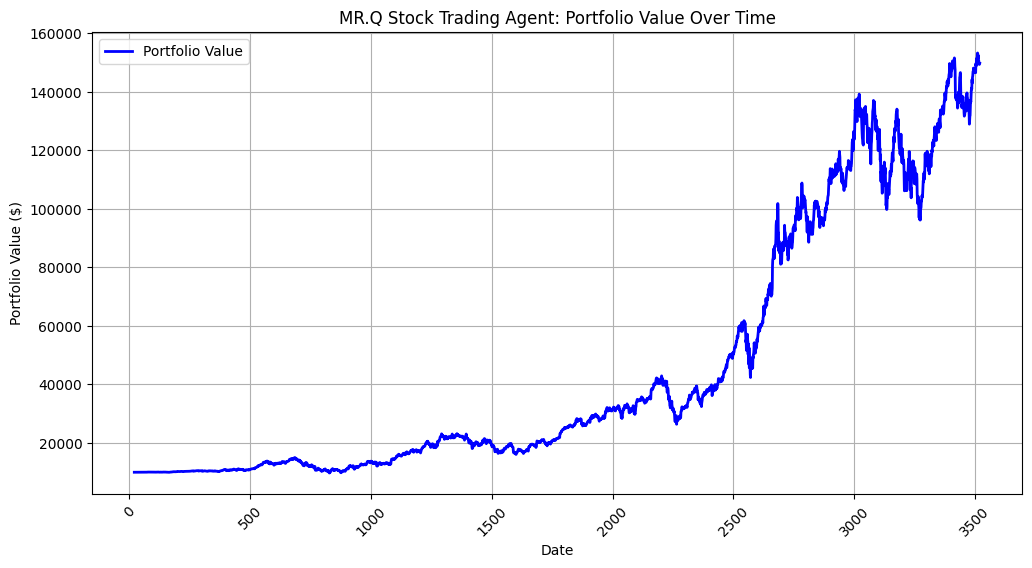

In [11]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(dates[:-1], portfolio_values, label="Portfolio Value", color="blue", linewidth=2)
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.title("MR.Q Stock Trading Agent: Portfolio Value Over Time")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis for better readability
plt.show()


## Test to make sure our action were executed

In [12]:
from collections import Counter

# Track actions taken
action_counts = Counter()

for i in range(len(data)-1):
    state = data.iloc[i].values
    action = agent.select_action(state)  # Get action (0=Hold, 1=Buy, 2=Sell)
    action_counts[action] += 1  # Count occurrences of each action

print("Action Distribution:", action_counts)


Action Distribution: Counter({1: 3079, 2: 215, 0: 207})


## Trading decisions

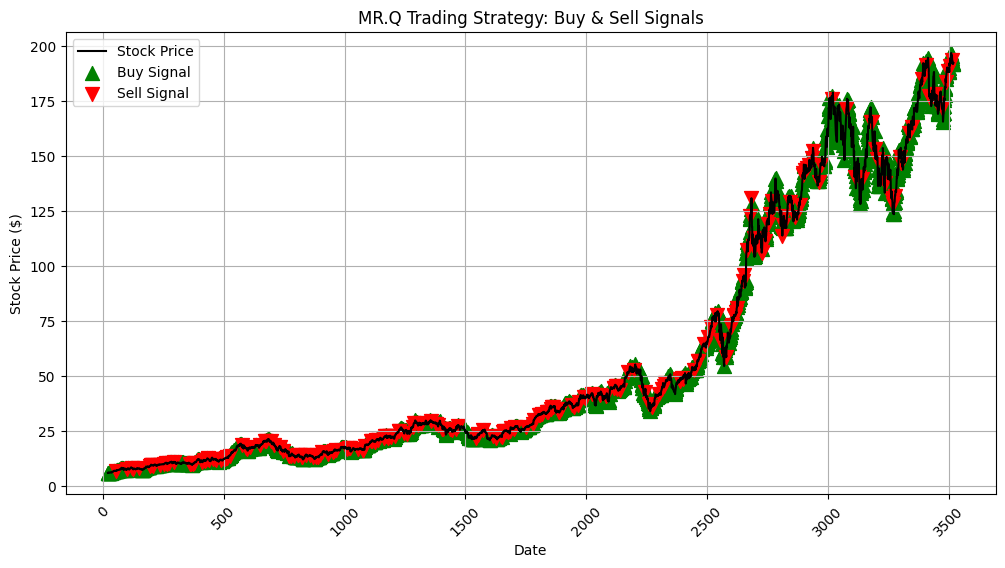

In [13]:
import matplotlib.pyplot as plt

# Store trade actions
buy_dates = []
sell_dates = []
hold_dates = []

for i in range(len(data) - 1):
    state = data.iloc[i].values
    action = agent.select_action(state)
    
    if action == 1:  # Buy
        buy_dates.append(dates[i])
    elif action == 2:  # Sell
        sell_dates.append(dates[i])
    else:  # Hold
        hold_dates.append(dates[i])

# Plot Stock Prices with Buy/Sell Markers
plt.figure(figsize=(12, 6))
plt.plot(dates[:-1], data["Close"][:-1], label="Stock Price", color="black")

# Buy & Sell markers
plt.scatter(buy_dates, data.loc[buy_dates, "Close"], label="Buy Signal", color="green", marker="^", alpha=1, s=100)
plt.scatter(sell_dates, data.loc[sell_dates, "Close"], label="Sell Signal", color="red", marker="v", alpha=1, s=100)

# Formatting
plt.xlabel("Date")
plt.ylabel("Stock Price ($)")
plt.title("MR.Q Trading Strategy: Buy & Sell Signals")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()